### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


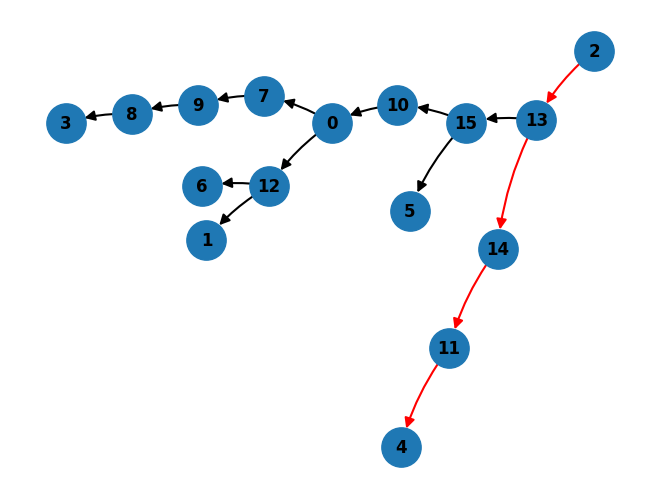

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

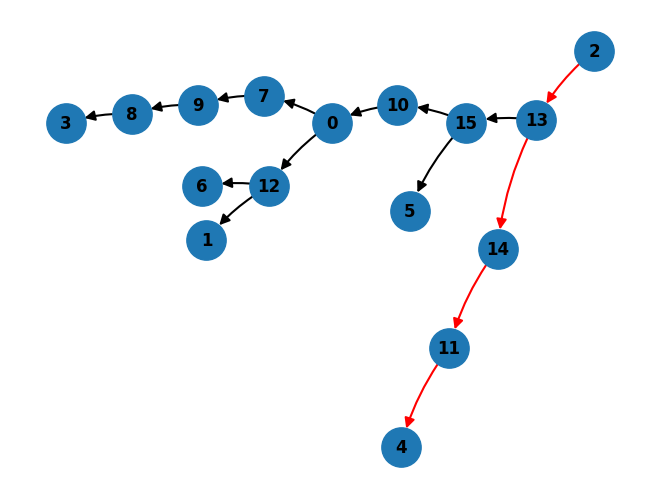

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [5]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

In [6]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


In [7]:
labels, cache = get_example_cache(pred, model, dataset)

In [8]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Experiment: understanding embeddings

In [9]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(all_nodes)

explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

NameError: name 'all_nodes' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score

X = all_nodes
y = np.zeros((32,))
y[16:] = 1.0

probe = LinearRegression().fit(X, y)
# Calculate train loss
y_pred = probe.predict(X)
loss = mean_squared_error(y, y_pred)
loss

: 

In [ ]:
def add_low_rank_hook(layer, k):
    
    X = []

    for i in range(1_000):
        # Sample example
        test_graph = generate_example(n_states, i, order="random")
        pred, correct = eval_model(model, dataset, test_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(pred, model, dataset)
        # Record information
        X.append(cache[f"blocks.{layer}.attn.hook_v"][0, [i for i in range(45) if (i-1) % 3 == 0], 0])

    X = torch.cat(X, dim=0).detach().cpu().numpy()

    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X)

    # Add low-rank hook

    from functools import partial

    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[:, position, 0, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[:, position, 0, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre


    temp_hook_fn = partial(low_rank_hook, position=[i for i in range(45) if (i-1) % 3 == 0])
    model.blocks[layer].attn.hook_v.add_hook(temp_hook_fn)

: 

In [ ]:
model.reset_hooks()
add_low_rank_hook(1, 16)
add_low_rank_hook(2, 16)
add_low_rank_hook(3, 16)
add_low_rank_hook(4, 16)
add_low_rank_hook(5, 16)

: 

In [ ]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

: 

In [ ]:
X = []

for i in range(1_000):
        # Sample example
        test_graph = generate_example(n_states, i, order="random")
        pred, correct = eval_model(model, dataset, test_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(pred, model, dataset)
        # Record information
        X.append(cache[f"blocks.{1}.attn.hook_v"][0, [i for i in range(45) if (i-1) % 3 == 0], 0])

X = torch.cat(X, dim=0).detach().cpu().numpy()

pca = PCA(n_components=k)  # k is the desired rank of the approximation
pca = pca.fit(X)

: 

In [ ]:
pca = PCA(n_components=16)  # k is the desired rank of the approximation
pca = pca.fit(X)

: 

In [ ]:
explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

: 

In [ ]:
imshow(pca.components_)

: 